In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc

In [3]:
# Loading the data
df = pd.read_csv("internet_service_churn.csv")

df.head()

,id,is_tv_subscriber,is_movie_package_subscriber,subscription_age,bill_avg,reamining_contract,service_failure_count,download_avg,upload_avg,download_over_limit,churn
0,15,1,0,11.95,25,0.14,0,8.4,2.3,0,0
1,18,0,0,8.22,0,NaN,0,0.0,0.0,0,1
2,23,1,0,8.91,16,0.00,0,13.7,0.9,0,1
3,27,0,0,6.87,21,NaN,1,0.0,0.0,0,1
4,34,0,0,6.39,0,NaN,0,0.0,0.0,0,1


In [5]:
# Exploring columns and row number
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72274 entries, 0 to 72273
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           72274 non-null  int64  
 1   is_tv_subscriber             72274 non-null  int64  
 2   is_movie_package_subscriber  72274 non-null  int64  
 3   subscription_age             72274 non-null  float64
 4   bill_avg                     72274 non-null  int64  
 5   reamining_contract           50702 non-null  float64
 6   service_failure_count        72274 non-null  int64  
 7   download_avg                 71893 non-null  float64
 8   upload_avg                   71893 non-null  float64
 9   download_over_limit          72274 non-null  int64  
 10  churn                        72274 non-null  int64  
dtypes: float64(4), int64(7)
memory usage: 6.1 MB


In [9]:
# Reducing sample size
# To reduce time of analysis, a smaller sample will be used

# Sample of 10% of the data (~around 7,000 rows)
df_sample = df.sample(frac=0.10)

print(f"Original rows: {df.shape[0]}")
print(f"Sampled rows: {df_sample.shape[0]}")

Original rows: 72274
Sampled rows: 7227


In [11]:
# Summary statistics
df_sample.describe()

,id,is_tv_subscriber,is_movie_package_subscriber,subscription_age,bill_avg,reamining_contract,service_failure_count,download_avg,upload_avg,download_over_limit,churn
count,7.227000e+03,7227.000000,7227.000000,7227.000000,7227.000000,5024.000000,7227.000000,7192.000000,7192.000000,7227.000000,7227.000000
mean,8.411282e+05,0.810295,0.332780,2.476693,19.090771,0.701162,0.248928,44.088724,4.311137,0.213643,0.562336
std,4.906915e+05,0.392095,0.471241,2.038553,14.168310,0.692000,0.743938,86.853101,11.582057,1.007317,0.496133
min,3.400000e+01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.112225e+05,1.000000,0.000000,0.930000,13.000000,0.000000,0.000000,6.675000,0.500000,0.000000,0.000000
50%,8.431910e+05,1.000000,0.000000,1.980000,19.000000,0.530000,0.000000,28.200000,2.100000,0.000000,1.000000
75%,1.260120e+06,1.000000,1.000000,3.390000,22.000000,1.300000,0.000000,60.700000,4.800000,0.000000,1.000000
max,1.689546e+06,1.000000,1.000000,12.300000,406.000000,2.510000,15.000000,4415.200000,327.200000,7.000000,1.000000


### Data Cleaning

In [13]:
# Checking for duplicates
df_sample.duplicated().value_counts()

False    7227
Name: count, dtype: int64

In [30]:
# There are no duplicates

In [15]:
# Checking for missing values
df_perc = (df_sample.isnull().sum().sort_values(ascending=False)/df_sample.shape[0])*100
df_perc

reamining_contract             30.482911
download_avg                    0.484295
upload_avg                      0.484295
id                              0.000000
is_tv_subscriber                0.000000
is_movie_package_subscriber     0.000000
subscription_age                0.000000
bill_avg                        0.000000
service_failure_count           0.000000
download_over_limit             0.000000
churn                           0.000000
dtype: float64

In [32]:
# 'reamining_contract' 
# null means customer do not have a contract and so, they will be kept as is

# 'download_avg' and 'upload_avg'
# since it represents only a small percentage, these will be dropped

In [17]:
# Creating new column 'has_contract'
df_sample['has_contract'] = df_sample['reamining_contract'].apply(lambda x: 0 if pd.isna(x) else 1)

In [19]:
# Imputing null values with 0
df_sample['reamining_contract'] = df_sample['reamining_contract'].fillna(0)

In [21]:
# Dropping 'download_avg' and 'upload_avg'
df_sample = df_sample.dropna(axis=0, subset=['download_avg','upload_avg'])

### Data Preprocessing

In [23]:
# Dropping irrelevant columns
df_sample = df_sample.drop(columns=['id'])

In [25]:
# Fixing column name
df_sample = df_sample.rename(columns={"reamining_contract":"remaining_contract"})

In [27]:
# Rearranging columns
column_names = ['is_tv_subscriber','is_movie_package_subscriber','subscription_age','bill_avg','remaining_contract',
                'has_contract','service_failure_count','download_avg','upload_avg','download_over_limit','churn']

df_sample = df_sample.reindex(columns=column_names)
df_sample.head()

,is_tv_subscriber,is_movie_package_subscriber,subscription_age,bill_avg,remaining_contract,has_contract,service_failure_count,download_avg,upload_avg,download_over_limit,churn
18723,1,1,6.24,21,1.76,1,0,42.9,3.6,0,0
37018,1,0,3.70,9,1.08,1,0,213.9,36.8,0,0
31365,1,0,2.78,20,0.00,0,0,11.5,0.4,0,1
68569,1,1,0.25,21,0.68,1,0,71.0,5.0,0,0
36237,1,1,3.82,22,1.29,1,2,103.0,156.6,0,0


### EDA

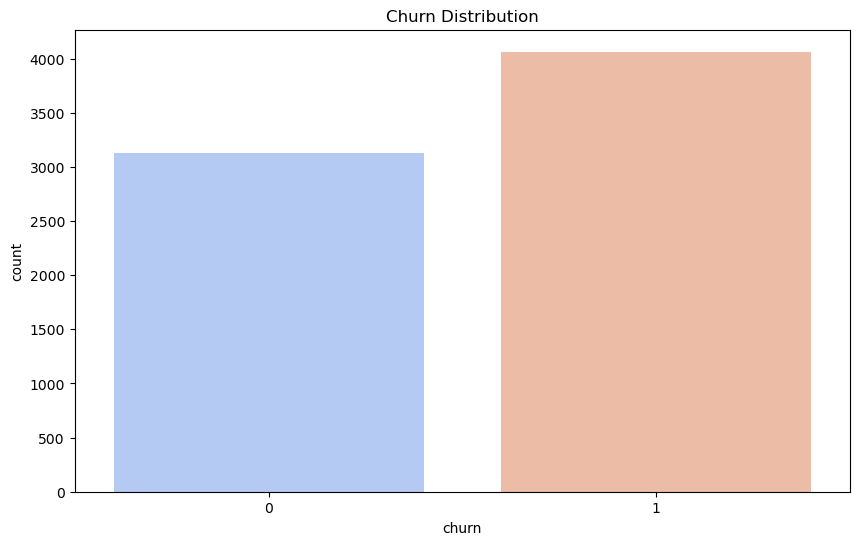

In [29]:
# Data Distribution
plt.figure(figsize=(10,6))
sns.countplot(x='churn', data=df_sample, palette='coolwarm', hue='churn', legend=False)
plt.title("Churn Distribution")
plt.show()

In [33]:
df_churn = df_sample['churn'].value_counts()

churn_rate = (df_churn[1]/(df_churn[0]+df_churn[1]))*100
print(f'Churn rate: {churn_rate:.2f}%')

Churn rate: 56.51%


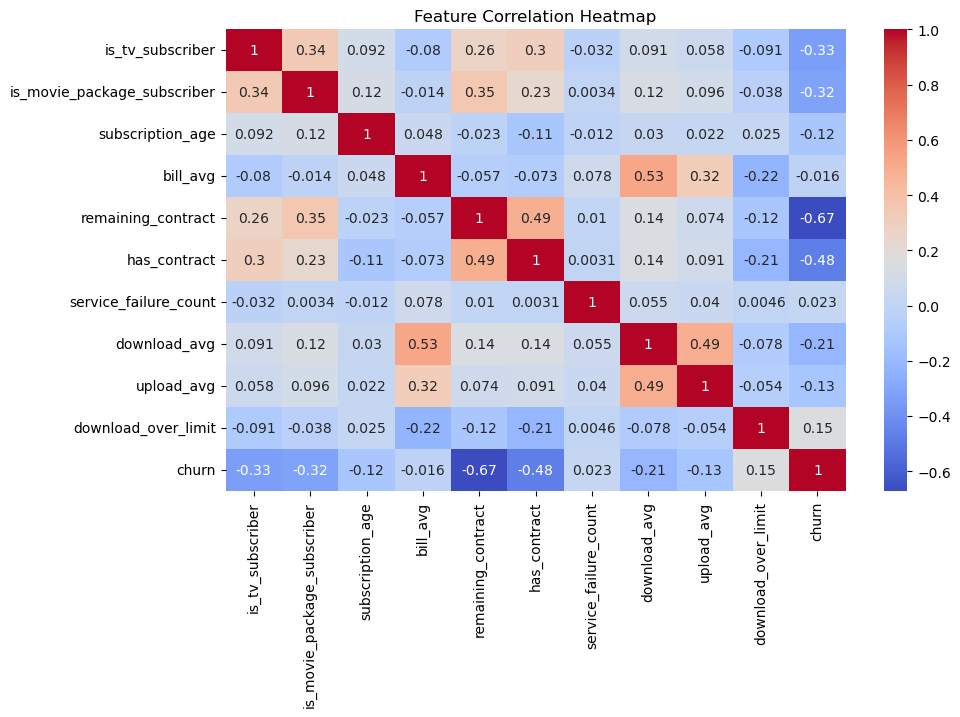

Feature Correlation with Target:
 churn                          1.000000
download_over_limit            0.152942
service_failure_count          0.023490
bill_avg                      -0.015735
subscription_age              -0.115041
upload_avg                    -0.127791
download_avg                  -0.214262
is_movie_package_subscriber   -0.315877
is_tv_subscriber              -0.334717
has_contract                  -0.475889
remaining_contract            -0.673178
Name: churn, dtype: float64


In [35]:
# Feature Correlation
plt.figure(figsize=(10,6))
sns.heatmap(df_sample.corr(),annot=True,cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

# Feature Correlation w/ Target
correlation_matrix = df_sample.corr()
correlated_features = correlation_matrix["churn"].sort_values(ascending=False)
print("Feature Correlation with Target:\n", correlated_features)

In [46]:
# Interesting findings

# 'remaining_contract' has the higher influence over 'churn'
# followed by: 'is_tv_subscriber', 'is_movie_package_subscriber', download_avg

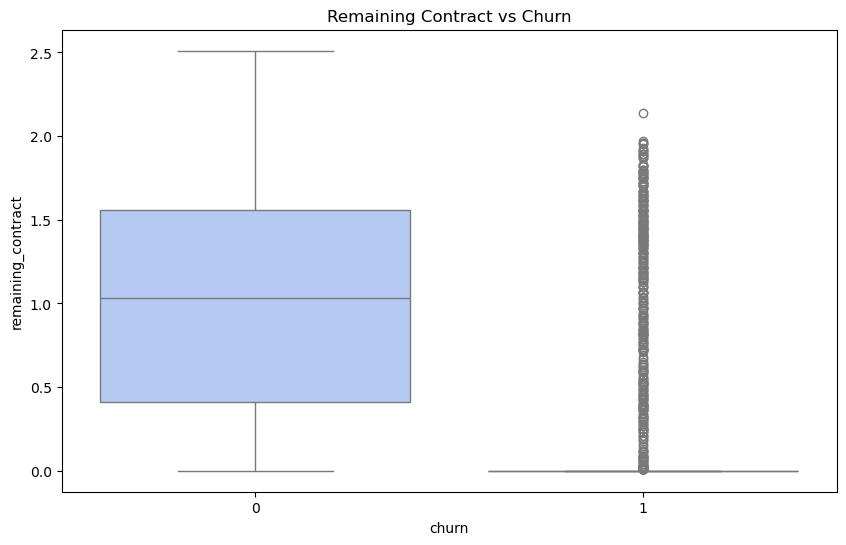

In [37]:
# Outliers Detection
plt.figure(figsize=(10,6))
sns.boxplot(x='churn', y='remaining_contract', data=df_sample, palette='coolwarm',  hue='churn', legend=False)
plt.title("Remaining Contract vs Churn")
plt.show()

### Training Random Forest Model 

In [39]:
# Training model

#Defining Features and Target variable
X = df_sample.drop(columns=('churn'),axis=1)
y = df_sample['churn']

# Split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

# Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [41]:
# Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train,y_train)

RandomForestClassifier(random_state=42)

In [43]:
# Making predictions
y_pred = rf_model.predict(X_test)

Accuracy: 0.8401667824878388
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.84      0.81       599
           1       0.88      0.84      0.86       840

    accuracy                           0.84      1439
   macro avg       0.83      0.84      0.84      1439
weighted avg       0.84      0.84      0.84      1439



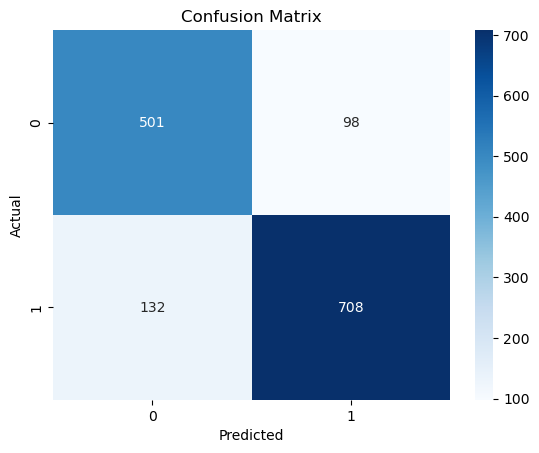

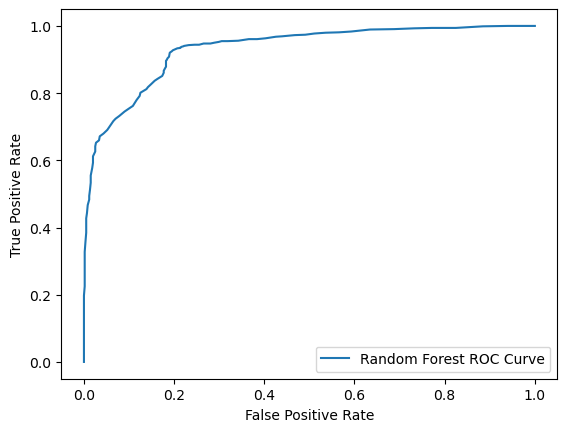

In [45]:
# Evaluating the Model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
y_probs = rf_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_probs)
plt.plot(fpr, tpr, label="Random Forest ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

In [47]:
# Interesting findings

# the model seems to be doing pretty accurate predictions with 84% of recall

### Hyperparameter Tuning

In [49]:
# Define parameter grid for tuning
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'max_depth': [5, 10, None],  # Maximum depth of each tree
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4]  # Minimum samples per leaf node
}

In [51]:
# Grid search
# Initialize the model
rf = RandomForestClassifier(random_state=42)

# Perform Grid Search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Display best parameters
print("Best Parameters Found: ", grid_search.best_params_)


Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Parameters Found:  {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}


Model Performance after Hyperparameter Tuning:
              precision    recall  f1-score   support

           0       0.78      0.84      0.81       599
           1       0.88      0.83      0.85       840

    accuracy                           0.83      1439
   macro avg       0.83      0.83      0.83      1439
weighted avg       0.84      0.83      0.84      1439

Accuracy: 0.8346073662265462


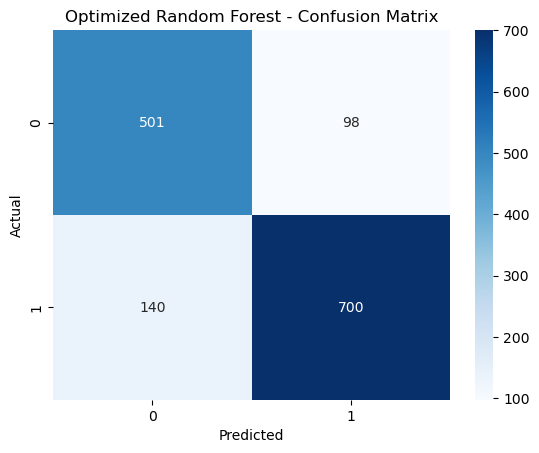

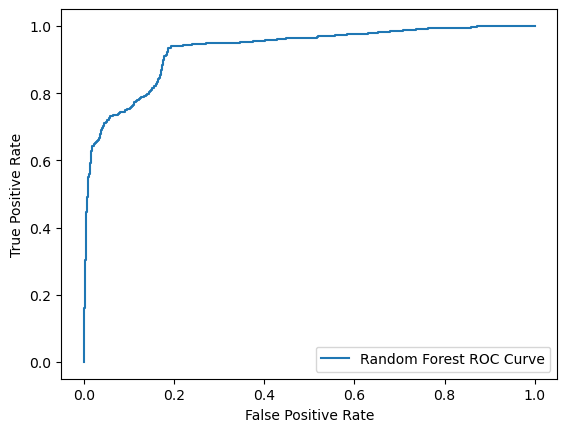

In [53]:
# Training the model with the best-found parameters
best_rf_model = grid_search.best_estimator_
best_rf_model.fit(X_train, y_train)

# Making predictions on test data
y_pred_best = best_rf_model.predict(X_test)

# Evaluating model performance
print("Model Performance after Hyperparameter Tuning:")
print(classification_report(y_test, y_pred_best))
print("Accuracy:", accuracy_score(y_test, y_pred_best))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Optimized Random Forest - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
y_probs = best_rf_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_probs)
plt.plot(fpr, tpr, label="Random Forest ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

In [55]:
# Cross-validation
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Initialize Stratified K-Fold with 5 splits
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [57]:
# Perform cross-validation
cv_scores = cross_val_score(best_rf_model, X_train, y_train, cv=cv, scoring='accuracy')

# Print cross-validation results
print("Cross-Validation Accuracy Scores:", cv_scores)
print("Mean CV Accuracy:", np.mean(cv_scores))
print("Standard Deviation of Accuracy:", np.std(cv_scores))

Cross-Validation Accuracy Scores: [0.91659427 0.93397046 0.9374457  0.93826087 0.92695652]
Mean CV Accuracy: 0.9306455634042232
Standard Deviation of Accuracy: 0.008078832453638506


### Model Interpretability

In [59]:
# SHAP Interpretation
!pip install shap lime

In [61]:
# Importing SHAP and LIME
import shap
import lime
import lime.lime_tabular

In [63]:
# Create SHAP explainer
explainer = shap.TreeExplainer(best_rf_model)
shap_values = explainer.shap_values(X_test)   # shape: (n_samples, n_features, 2)

# Check SHAP output format
print("shap_values shape:", shap_values.shape)  # should be (n_samples, n_features, 2)

shap_values shape: (1439, 10, 2)


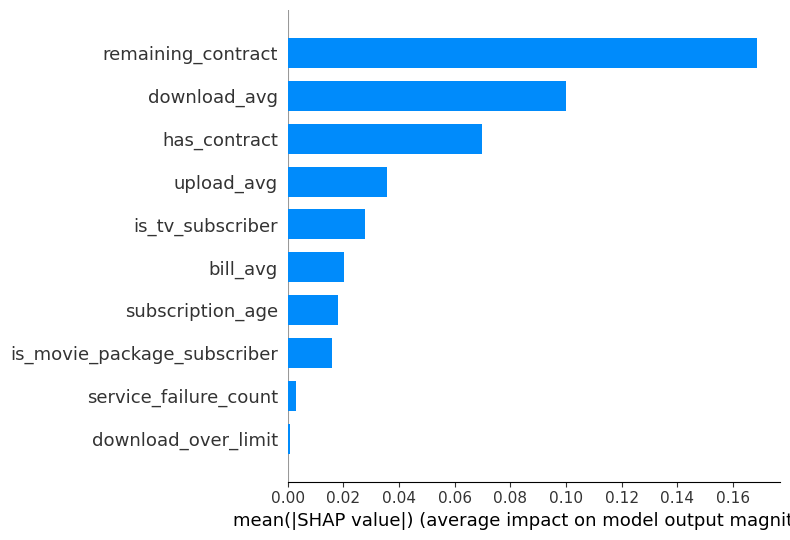

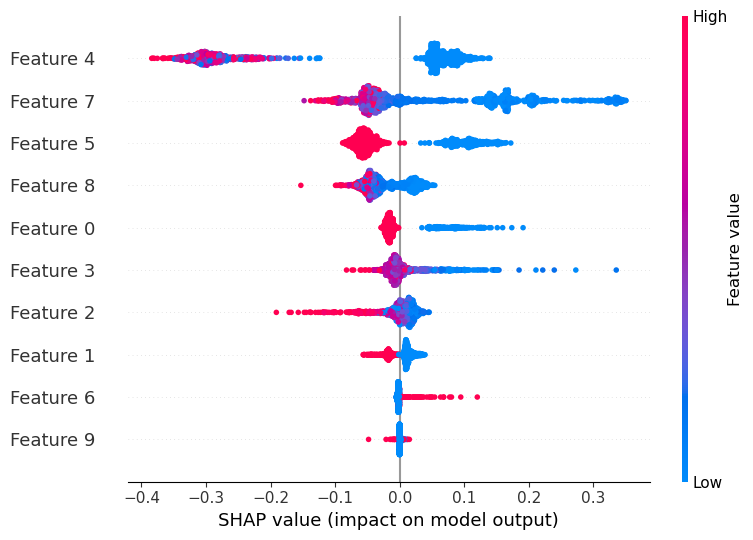

In [97]:
# Global Summary plot
# Bar plot – shows global feature importance
shap.summary_plot(shap_values[:, :, 1], X, plot_type="bar")

# Full distribution plot – more detailed, shows impact per feature per prediction
shap.summary_plot(shap_values[:, :, 1], X_test)

In [91]:
# Get mean absolute SHAP values
mean_shap = np.abs(shap_values[:, :, 1]).mean(axis=0)

# Get top 5 features
top_features = pd.Series(mean_shap, index=X.columns).sort_values(ascending=False).head(5)
print("Top SHAP features:\n", top_features)

Top SHAP features:
 remaining_contract    0.168449
download_avg          0.100006
has_contract          0.069774
upload_avg            0.035653
is_tv_subscriber      0.027967
dtype: float64


In [99]:
# Create a LIME explainer object
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X.columns.tolist(),
    class_names=["No Churn", "Churn"],
    mode="classification",
    discretize_continuous=True
)

sample_idx = 10

In [101]:
# Explain the instance
exp = lime_explainer.explain_instance(
    data_row=np.array(X_test[sample_idx]),
    predict_fn=rf_model.predict_proba,
    num_features=10  # Show top 10 feature contributions
)

# Show in notebook
exp.show_in_notebook()